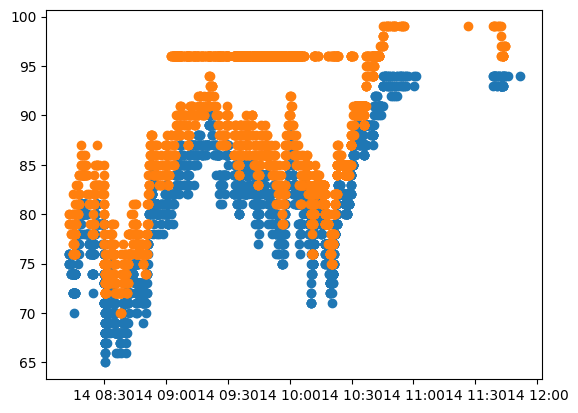

In [23]:
# Plot a market
import matplotlib.pyplot as plt 
data = db.read("INXZ-23SEP14-T4467.44")
ob = [i for i in data]
bbos = [(o.get_bbo(), o.ts) for o in ob]
bids = [(o.bid,ts) for o,ts in bbos if o is not None]
bids = [(o.price, ts) for o, ts in bids if o is not None]
asks =  [(o.ask,ts) for o,ts in bbos if o is not None]
asks = [(o.price,ts) for o,ts in asks if o is not None]
plt.scatter([ts for _, ts in bids], [p for p, _ in bids])
plt.scatter([ts for _, ts in asks], [p for p, _ in asks])
plt.show()

In [53]:
import datetime
####### START HERE ############
from data.coledb.coledb import ColeDBInterface
date = "2023-09-14"
end_time = "16:00:00"  # 4 pm
datetime_str = f"{date} {end_time}"
dt_object = datetime.datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
formatted_date = dt_object.strftime('%y%b%d').upper()
close_time_unix = int(dt_object.timestamp())
filename = f"/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/research/bbo_INXZ_and_SPY_{date}.csv"
from data.coledb.coledb import ColeDBInterface
db = ColeDBInterface()
cole_db_path = db.cole_db_storage_path / f"INXZ/{formatted_date}"
market_suffix = list(cole_db_path.iterdir())[0].name
start_day_price = float(market_suffix[1:])*10

In [54]:
# Create file ONLY RUN THIS ONCE
assert False
from strategy.utils import get_spy_ob_bbo_merged_df
from helpers.types.markets import MarketTicker
date_no_hyphen = date.replace("-","")
df = get_spy_ob_bbo_merged_df(db, f"/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/databento/xnas-itch/spy/xnas-itch-{date_no_hyphen}.mbo.csv", MarketTicker(f"INXZ-{formatted_date}-{market_suffix}"))
df.to_csv(filename)

/Users/kamyarghiam/Desktop/kalshi_bot/src/strategy/utils.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


1. first clean data, remove rows with nan spy. Then, divide spy price by 10000000 (to convert to cents). Take all times between 9:30 AM an d 4 PM
2. lag ES data by certain amount of time (maybe 0 seconds, 500 millis, 1 second, 2 seconds, 3 seconds, 4 seconds, 5 seconds, 10 seconds)
3. for each lagged df, tune hyper params 
4. params to tune are: m,b, and shift_up

In [68]:

# Load data (instead of creating)
import pandas as pd

# LOAD DATA
df = pd.read_csv(filename)

# First remove any rows with nan spy (cleaned_df)
cdf = df[df['spy_price'].notna()]
cdf['spy_price'] /= 10000000
cdf = cdf[(cdf.ts >= close_time_unix - 23400) & (cdf.ts <= close_time_unix)]
cdf = cdf[((cdf.yes_bid_price).notna()) & ((cdf.yes_ask_price).notna())]
# Next (skipped) lag the data
...


/var/folders/bq/3lxf2pcx7s9crrr7kqds7d_00000gn/T/ipykernel_7463/4138769442.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['spy_price'] /= 10000000


Ellipsis

In [69]:
import numpy as np
from scipy.optimize import basinhopping, minimize


def get_cdf_with_params(x):
    m = x[0]
    b = x[1]
    shift_up = x[2]
    c = x[3]
    """Minimization functions for the bids"""
    cdf['w'] = m *(close_time_unix - df.ts) + b
    cdf['sigmoid'] = (1 / (1 + np.exp(-1*(start_day_price - cdf.spy_price)*c + (cdf.w)))) + shift_up
    return cdf

def minimize_bids(x):
    cdf = get_cdf_with_params(x)
    # Adjust below for bids (yes_ask_price)
    return abs((100*cdf.sigmoid) - cdf.yes_bid_price).sum()
def callback(x, f=None, accepted= None):
    print(f"Iteration {callback.iteration}: x = {x}, f(x) = {f}, accepted = {accepted}")
    callback.iteration += 1
callback.iteration = 0
# Nelder-Mean method
result = minimize(
        minimize_bids,
        [ 1.28003367e-04, -2.43661709e+00, -5.90389385e-02, -1.36643951e-02],
        method="Nelder-Mead",
        callback=callback

    )
# Basin-hopping
# result = basinhopping(
#         minimize_bids,
#         [-1.84779063e-07, -4.70240335e-04, -4.52495123e-01],
#         stepsize=0.1,
#         callback=callback
#     )
# Best so far:
# 9/14/23
# [-9.22317446e-05 -1.49928441e+02 -1.44133974e-01 -3.92811769e-03]
# 10/02/23
# [-9.22334475e-05,  5.57050388e-01, -1.44128967e-01, -3.92815356e-03]
# 10/18/23
# [-1.26921421e-04,  2.21516983e-01,  8.14942902e-03, -9.63582632e-03]
minimize_bids(result.x)

Iteration 0: x = [ 8.65386455e-05 -1.86232546e+00  2.48433113e-02 -7.82177983e-03], f(x) = None, accepted = None
Iteration 1: x = [ 8.65386455e-05 -1.86232546e+00  2.48433113e-02 -7.82177983e-03], f(x) = None, accepted = None
Iteration 2: x = [ 8.77555952e-05 -1.93798243e+00  2.51926704e-02 -7.56512768e-03], f(x) = None, accepted = None
Iteration 3: x = [ 8.77555952e-05 -1.93798243e+00  2.51926704e-02 -7.56512768e-03], f(x) = None, accepted = None
Iteration 4: x = [ 8.77555952e-05 -1.93798243e+00  2.51926704e-02 -7.56512768e-03], f(x) = None, accepted = None
Iteration 5: x = [ 8.93792512e-05 -1.90038128e+00  2.41837141e-02 -7.62499409e-03], f(x) = None, accepted = None
Iteration 6: x = [ 8.93792512e-05 -1.90038128e+00  2.41837141e-02 -7.62499409e-03], f(x) = None, accepted = None
Iteration 7: x = [ 8.93792512e-05 -1.90038128e+00  2.41837141e-02 -7.62499409e-03], f(x) = None, accepted = None
Iteration 8: x = [ 9.07581571e-05 -2.06163259e+00  2.36527952e-02 -7.16964061e-03], f(x) = None,

112263.1618406272

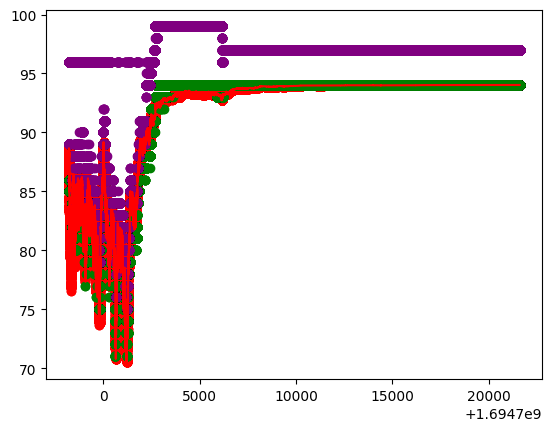

In [70]:
import matplotlib.pyplot as plt 
cdf_with_params = get_cdf_with_params(result.x)

plt.plot(cdf_with_params.ts, cdf_with_params.sigmoid*100, color = 'red')
plt.scatter(cdf_with_params.ts, cdf_with_params.sigmoid*100, color = 'red')
plt.scatter(cdf_with_params.ts, cdf_with_params.yes_bid_price, color ='green')
plt.scatter(cdf_with_params.ts, cdf_with_params.yes_ask_price, color = 'purple')
plt.show()

##### TODO:

1. (done) Figure out good bounds for hyper params -- it's returning the same values everywhere (find out why). You might need to use diff optimizations
2. **TODO** figure out why it's inversely correlated
3. Run for asks as well 
4. Finally, try to lag the data some time 

In [12]:
cdf.spy_price - start_day_price

1552     -377.0
1553     -377.0
1554     -377.0
1555     -377.0
1556     -377.0
          ...  
234488   -708.0
234489   -707.0
234490   -707.0
234491   -707.0
234492   -707.0
Name: spy_price, Length: 232941, dtype: float64

In [13]:
start_day_price

43732.0

In [14]:
cdf.spy_price

1552      43355.0
1553      43355.0
1554      43355.0
1555      43355.0
1556      43355.0
           ...   
234488    43024.0
234489    43025.0
234490    43025.0
234491    43025.0
234492    43025.0
Name: spy_price, Length: 232941, dtype: float64